In [7]:
# Imports
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import random
from copy import deepcopy
import gymnasium as gym


import os
from IPython.display import clear_output

import matplotlib.pyplot as plt
from config.config_continuous import config_dict

In [8]:
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc2_mean = nn.Linear(hidden_size, output_size)  # Pour la moyenne
        self.fc2_logstd = nn.Linear(hidden_size, output_size)  # Pour la log-variance

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        mean = self.fc2_mean(x)
        log_std = self.fc2_logstd(x)
        return mean, log_std  # Retourne la moyenne et la log-variance



In [9]:

from torch.utils.tensorboard import SummaryWriter
from datetime import datetime


class ContinuousPPO:
    def __init__(
        self,
        action_space,
        observation_space,
        gamma,
        episode_batch_size,
        actor_learning_rate,
        critic_learning_rate,
        lambda_=0.95,
        writer=None,
    ):
        self.action_space = action_space
        self.observation_space = observation_space
        self.gamma = gamma
        self.lambda_ = lambda_
        self.eps = 0.2
        self.writer = SummaryWriter( log_dir="runs/ppo_continuous_" + datetime.now().strftime("%Y%m%d-%H%M%S")) 
        self.episode_batch_size = episode_batch_size
        self.actor_learning_rate = actor_learning_rate
        self.critic_learning_rate = critic_learning_rate

        self.loss_function = nn.MSELoss()

        # Reset
        hidden_size = 64
        
        obs_size = self.observation_space.shape[0] * self.observation_space.shape[1] * self.observation_space.shape[2]
        action_dim = self.action_space.shape[0]


        self.actor = Net(obs_size, hidden_size, action_dim)
        self.critic = Net(obs_size, hidden_size, 1)

        self.optimizer = optim.Adam(
            params=self.actor.parameters(), lr=self.actor_learning_rate
        )

        self.critic_optimizer = optim.Adam(
            params=self.critic.parameters(), lr=self.critic_learning_rate
        )
        self.current_episode = []
        self.episode_reward = 0

        self.scores = []

        self.n_eps = 0
        self.total_steps = 0
        self.critic_updates = 0

    def get_action(self, state, epsilon=None):
        
        state_tensor = torch.tensor(state.flatten()).unsqueeze(0).float()
        with torch.no_grad():
            mean, log_std = self.actor(state_tensor)  # Récupérer la moyenne et la log-variance
            std = torch.exp(log_std)  # L'écart-type est l'exponentielle de la log-variance
            dist = torch.distributions.Normal(mean, std)
            action = dist.sample()  # Échantillonner une action à partir de la distribution
            log_prob = dist.log_prob(action).sum(dim=-1)  # Calculer la log-probabilité
        return action, log_prob

    def compute_GAE(self, rewards, terminateds, advantages):
        """
        Generalized Advantage Estimation
        """
        GAE = 0
        GAE_list = []
        for t in reversed(range(len(rewards))):
            GAE = (1 - terminateds[t]) * GAE
            GAE = advantages[t] + self.gamma * self.lambda_ * GAE
            GAE_list.append(GAE)
        return torch.tensor(GAE_list[::-1], dtype=torch.float32)

    def compute_ppo_score(self):
        states, actions, rewards, terminals, next_states, old_log_probs = tuple(
            [torch.cat(data) for data in zip(*self.current_episode)]
        )
        
        next_states = next_states.view(next_states.size(0), -1)
        
        with torch.no_grad():
            output = self.critic(next_states)
            while isinstance(output, tuple):
                output = output[0]

            target_values = (
                rewards
                + self.gamma * (1 - terminals) * output.squeeze()
            )
            states = states.view(states.size(0), -1)
            values = self.critic(states)
            while isinstance(values, tuple):
                values = values[0]
            values = values.squeeze()
            advantages = target_values - values

        GAEs = self.compute_GAE(rewards, terminals, advantages)
        std = GAEs.std()
        GAEs = (GAEs - GAEs.mean()) / ( std + 1e-8 )

        # Calcul des log-probabilités pour les actions continues
        mean, log_std = self.actor(states)
        std = torch.exp(log_std)
        dist = torch.distributions.Normal(mean, std)
        log_probs = dist.log_prob(actions).sum(dim=-1)

        ratio = torch.exp(log_probs - old_log_probs)

        clipped_ratio = torch.clamp(ratio, 1 - self.eps, 1 + self.eps)
        policy_loss = -torch.min(ratio * GAEs, clipped_ratio * GAEs).mean()
        

        # Perte de valeur (Critic loss)
        value_loss = self.loss_function(values, target_values)
        
        # Calcul de l'entropie pour les actions continues
        entropy = 0.5 + 0.5 * np.log(2 * np.pi) + log_std.mean()
        entropy_loss = -0.01 * entropy  # Coefficient d'entropie

        # Perte totale
        total_loss = policy_loss + 0.5 * value_loss + entropy_loss
        if self.writer:
            probs = torch.softmax(mean, dim=-1)

            entropy = -(probs * torch.log_softmax(mean, dim=-1)).sum(dim=1).mean()
            self.writer.add_scalar("policy/entropy", entropy.item(), self.n_eps)

        return total_loss.sum().unsqueeze(0)



    def train_reset(self):
        self.current_episode = []
        self.episode_reward = 0
        self.scores = []

    def update_critic(self, transition):
        state, _, reward, terminated, next_state, _ = transition
        
        values = self.critic.forward(state)
        next_state = next_state.flatten()
        
        with torch.no_grad():
            next_state_values = (1 - terminated) * self.critic(next_state)[0]
            
            targets =  reward + next_state_values * self.gamma
        
        loss = self.loss_function(values[0].float(), targets.unsqueeze(1).float())
        if self.writer:
            self.writer.add_scalar("loss/critic", loss.item(), self.total_steps)
        
        self.critic_optimizer.zero_grad()
        loss.backward()
        # torch.nn.utils.clip_grad_value_(self.critic.parameters(), 5)
        self.critic_optimizer.step()

    def update(self, state, action, reward, terminated, next_state):
        state_tensor = torch.tensor(state.flatten(), dtype=torch.float32).unsqueeze(0)
        action_tensor = torch.tensor(action, dtype=torch.float32).unsqueeze(0)
        
        with torch.no_grad():
            mean, log_std = self.actor(state_tensor)
            std = torch.exp(log_std)
            dist = torch.distributions.Normal(mean, std)
            old_log_probs = dist.log_prob(action_tensor).sum(dim=-1)
            
        transition = (
            state_tensor,
            action_tensor,
            torch.tensor([reward], dtype=torch.float32),
            torch.tensor([terminated], dtype=torch.float32),
            torch.tensor(next_state.flatten(), dtype=torch.float32).unsqueeze(0),
            old_log_probs,
        )

        self.total_steps += 1
        self.episode_reward += reward

        self.current_episode.append(transition)
        self.update_critic(transition)

        if terminated:
            self.writer.add_scalar("policy/reward", self.episode_reward, self.n_eps)
            self.episode_reward = 0
            self.n_eps += 1
            
            # Mise à jour de l'acteur à la fin de chaque épisode au lieu d'attendre batch_size épisodes
            if len(self.current_episode) > 0:
                # Mise à jour de l'acteur
                self.optimizer.zero_grad()
                loss = self.compute_ppo_score()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.actor.parameters(), max_norm=0.5)
                self.optimizer.step()
                
                if self.writer:
                    self.writer.add_scalar("loss/total", loss.item(), self.n_eps)
                
                self.current_episode = []

In [10]:
class RandomAgent: 
    def __init__(self, observation_space, action_space):
        self.action_space = action_space
        return
    
    def get_action(self, state, *args):
        return self.action_space.sample()
    
    def update(self, *data):
        pass

In [15]:
def eval_agent(agent, env, n_sim=5):
    """
    ** Solution **
    
    Monte Carlo evaluation of DQN agent.

    Repeat n_sim times:
        * Run the DQN policy until the environment reaches a terminal state (= one episode)
        * Compute the sum of rewards in this episode
        * Store the sum of rewards in the episode_rewards array.
    """
    env_copy = deepcopy(env)
    episode_rewards = np.zeros(n_sim)
    for i in range(n_sim):
        state, _ = env_copy.reset()
        reward_sum = 0
        done = False
        while not done: 
            action_tensor = agent.get_action(state, 0)[0]  # Extrait le premier élément du tuple
            
            action = action_tensor.squeeze(0)
            action = action.numpy()
            state, reward, terminated, truncated, info= env_copy.step(action)
            reward_sum += reward
            on_road = info["rewards"].get("on_road_reward", True)  # Default to True if key is missing
            done = done or truncated or (not on_road)
            done = terminated or truncated or (not on_road)
        episode_rewards[i] = reward_sum
    return episode_rewards

In [ ]:
import highway_env
%matplotlib inline

env = gym.make("racetrack-v0", render_mode='rgb_array')
env.unwrapped.configure(config_dict)
obs, info = env.reset()
agent = RandomAgent(env.observation_space, env.action_space)
def run_one_episode(env, agent, display=True):
    display_env = deepcopy(env)
    done = False
    state, _ = display_env.reset()

    rewards = 0

    while not done:
        action_tensor = agent.get_action(state)  # Extrait le premier élément du tuple
        try:
            action = np.array(action_tensor[0])
        except:
            action = np.array(action_tensor)
        state, reward, done, truncated, info = display_env.step(action.numpy())
        on_road = info["rewards"].get("on_road_reward", True)  # Default to True if key is missing
        done = done or truncated or (not on_road)
        print(f"done {done} truncated {truncated}")
        rewards += reward
        if display: 
            clear_output(wait=True)
            plt.imshow(display_env.render())
            plt.show()
    if display:
        display_env.close()
    print(f'Episode length {rewards}')
    
run_one_episode(env, agent, display=True)
#print(f'Average over 5 runs : {np.mean(eval_agent(agent, env))}')

IndexError: index 1 is out of bounds for axis 0 with size 1

In [ ]:
import gymnasium as gym

    
env = gym.make("racetrack-v0", render_mode='rgb_array')
env.unwrapped.config.update(config_dict)
obs, info = env.reset()
action_space = env.action_space
observation_space = env.observation_space

gamma = 0.95
batch_size = 5


actor_lr = 5e-4
critic_lr = 1e-3

arguments = (
    action_space,
    observation_space,
    gamma,
    batch_size,              # rename for clarity if needed
    actor_lr,
    critic_lr
)




N_episodes = 500

agent = ContinuousPPO(*arguments)


def train(env, agent, N_episodes, eval_every=10, reward_threshold=300):
    total_time = 0
    state, _ = env.reset()
    losses = []
    for ep in range(N_episodes):
        done = False
        state, _ = env.reset()
        while not done: 
            state.flatten()
            action_tensor = agent.get_action(state)[0]  # Extrait le premier élément du tuple
            action = action_tensor.squeeze(0)   # Enlève la première dimension (batch) et convertit en np.array

            action = np.array(action)
            next_state, reward, terminated, truncated, info = env.step(action)
            on_road = info["rewards"].get("on_road_reward", True)  # Default to True if key is missing
            done = terminated or truncated or (not on_road)
                                            
            loss_val = agent.update(state, action, reward, done, next_state)

            state = next_state
            losses.append(loss_val)
            

        if ((ep+1)% eval_every == 0):
            rewards = eval_agent(agent, env)
            print("episode =", ep+1, ", reward = ", np.mean(rewards))
            if np.mean(rewards) >= reward_threshold:
                break
                
    return losses

    
# Run the training loop
losses = train(env, agent, N_episodes)

plt.plot(losses)

# Evaluate the final policy
rewards = eval_agent(agent, env, 20)
print("")
print("mean reward after training = ", np.mean(rewards))

episode = 10 , reward =  7.621009905437174
episode = 20 , reward =  7.956120064045619
episode = 30 , reward =  5.21272981996118
episode = 40 , reward =  6.298177101117256
episode = 50 , reward =  8.830050724533308
episode = 60 , reward =  6.826909720281729
episode = 70 , reward =  6.116939001679404


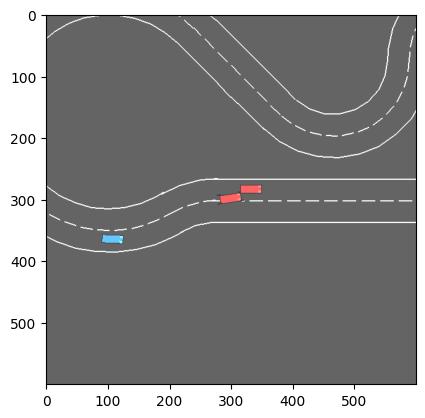

Episode length 316.4605487862365


In [ ]:
run_one_episode(env, agent, display=True)

In [ ]:
class NetContinousActions(nn.Module):
    """
    Basic neural net.
    """

    def __init__(self, obs_dim, hidden_size, act_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_dim, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, act_dim),
        )
        self.log_std = nn.Parameter(
            torch.zeros(act_dim)
        )  # learnable log std for Gaussian policy

    def forward(self, obs):
        mean = self.net(obs)
        std = self.log_std.exp()
        return mean, std


In [ ]:
class REINFORCEContinuous:
    def __init__(
        self,
        action_space,
        observation_space,
        gamma,
        episode_batch_size,
        learning_rate,
        writer=None,
    ):
        self.action_space = action_space
        self.observation_space = observation_space
        self.gamma = gamma

        self.episode_batch_size = episode_batch_size
        self.learning_rate = learning_rate
        self.writer = writer

        # Reset
        hidden_size = 128

        obs_size = self.observation_space.shape[0] * self.observation_space.shape[1] * self.observation_space.shape[2]
        actions_dim = self.action_space.shape[0]

        self.policy_net = NetContinousActions(obs_size, hidden_size, actions_dim)

        self.scores = []
        self.current_episode = []

        self.optimizer = optim.Adam(
            params=self.policy_net.parameters(), lr=self.learning_rate
        )

        self.n_eps = 0

    def update(self, state, action, reward, terminated, next_state):
        self.current_episode.append(
            (
                torch.tensor(state).unsqueeze(0),
                torch.tensor(action, dtype=torch.float32).unsqueeze(0),
                torch.tensor(reward, dtype=torch.float32).unsqueeze(0),
            )
        )

        if terminated:
            self.n_eps += 1

            states, actions, rewards = tuple(
                [torch.cat(data) for data in zip(*self.current_episode)]
            )

            current_episode_returns = self._returns(rewards, self.gamma)
            current_episode_returns = (
                current_episode_returns - current_episode_returns.mean()
            ) / current_episode_returns.std()
            # discounts = torch.pow(self.gamma, torch.arange(len(rewards)))
            states = states.view(states.size(0), -1)
            means, stds = self.policy_net.forward(states)
            dist = torch.distributions.Normal(means, stds)
            log_probs = dist.log_prob(actions).sum(dim=-1)

            score = log_probs * current_episode_returns  # * discounts

            self.scores.append(score.sum().unsqueeze(0))
            self.current_episode = []


            if (self.n_eps % self.episode_batch_size) == 0:
                self.optimizer.zero_grad()
                full_neg_score = -torch.cat(self.scores).sum() / self.episode_batch_size
                full_neg_score.backward()

                torch.nn.utils.clip_grad_norm_(
                    self.policy_net.parameters(), max_norm=1.0
                )
                self.optimizer.step()

                
                self.scores = []

        return

    def _returns(self, rewards, gamma):
        """ """
        returns = []
        G = 0
        for r in reversed(rewards):
            G = r + gamma * G
            returns.insert(0, G)
        return torch.tensor(returns, dtype=torch.float32)

    def get_action(self, state, epsilon=None):
        """ """
        state_tensor = (
            torch.as_tensor(state, dtype=torch.float32).flatten().unsqueeze(0)
        )
        with torch.no_grad():
            mean, std = self.policy_net(state_tensor)
            action = torch.distributions.Normal(mean, std).sample()
            low = torch.tensor(self.action_space.low)
            high = torch.tensor(self.action_space.high)
            return action.clamp(low, high).numpy()[0]

    def train_reset(self):
        self.scores = []
        self.current_episode = []

    def reset(self):
        hidden_size = 128

        obs_size = self.observation_space.shape[0]
        actions_dim = self.action_space.shape[0]

        self.policy_net = NetContinousActions(obs_size, hidden_size, actions_dim)

        self.scores = []
        self.current_episode = []

        self.optimizer = optim.Adam(
            params=self.policy_net.parameters(), lr=self.learning_rate
        )

        self.n_eps = 0


In [ ]:
import gymnasium as gym

    
env = gym.make("racetrack-v0", render_mode='rgb_array')
env.unwrapped.config.update(config_dict)
obs, info = env.reset()
action_space = env.action_space
observation_space = env.observation_space

gamma = 0.95
batch_size = 5


actor_lr = 5e-4
critic_lr = 1e-3

arguments = (
    action_space,
    observation_space,
    gamma,
    batch_size,              # rename for clarity if needed
    actor_lr,
    critic_lr
)

agent = REINFORCEContinuous(*arguments)



N_episodes = 500

#agent = ContinuousPPO(*arguments)


def train(env, agent, N_episodes, eval_every=10, reward_threshold=300):
    total_time = 0
    state, _ = env.reset()
    losses = []
    for ep in range(N_episodes):
        done = False
        state, _ = env.reset()
        while not done: 
            state.flatten()
            action_tensor = agent.get_action(state)[0]  # Extrait le premier élément du tuple
            action = action_tensor.squeeze(0)   # Enlève la première dimension (batch) et convertit en np.array

            action = np.array([action])
            next_state, reward, terminated, truncated, info = env.step(action)
            on_road = info["rewards"].get("on_road_reward", True)
            done = terminated or truncated or (not on_road)
            loss_val = agent.update(state, action, reward, done, next_state)

            state = next_state
            losses.append(loss_val)

            
            total_time += 1

        if ((ep+1)% eval_every == 0):
            rewards = eval_agent(agent, env)
            print("episode =", ep+1, ", reward = ", np.mean(rewards))
            if np.mean(rewards) >= reward_threshold:
                break
                
    return losses

    
# Run the training loop
losses = train(env, agent, N_episodes)

plt.plot(losses)

# Evaluate the final policy
rewards = eval_agent(agent, env, 20)
print("")
print("mean reward after training = ", np.mean(rewards))

episode = 10 , reward =  8.963257965347832
episode = 20 , reward =  6.178666309653676
episode = 30 , reward =  6.903009863944772
episode = 40 , reward =  5.978077839028659
episode = 50 , reward =  5.21868445509112
episode = 60 , reward =  10.63696340647139
episode = 70 , reward =  8.002335558514755
episode = 80 , reward =  14.387552407856328
episode = 90 , reward =  11.3025331775272
episode = 100 , reward =  24.07472614286081
episode = 110 , reward =  18.26818283703865
episode = 120 , reward =  5.7733257388073325
episode = 130 , reward =  6.903622368929507
episode = 140 , reward =  9.688435128342016
episode = 150 , reward =  19.957281082267475
episode = 160 , reward =  17.084277668122493
episode = 170 , reward =  13.846186599220484
episode = 180 , reward =  12.506736142436123
episode = 190 , reward =  17.423673406032215
episode = 200 , reward =  14.54028883866198
episode = 210 , reward =  28.427730411931634
episode = 220 , reward =  16.172523169320186
episode = 230 , reward =  36.13937

In [ ]:
run_one_episode(env, agent, display=True)

NameError: name 'run_one_episode' is not defined